# Vector Addition

:label:`ch_vector_add_cpu`


In this section, we will optimize the vector addition defined in :numref:`ch_vector_add` on CPU.

In [1]:
%matplotlib inline
import d2ltvm
import inspect
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import timeit
import tvm

We first define reusable plot functions to draw multiple lines, which generalize the plot function defined in :numref:`ch_call_overhead`.

In [2]:
# Save to the d2ltvm package.
def plot(X, Y, xlabel=None, ylabel=None, legend=[], xlim=None,
         ylim=None, xscale='linear', yscale='linear', fmts=None,
         figsize=(4.5, 3)):
    """Plot multiple lines"""
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize
    axes = plt.gca()
    X, Y = np.array(X), np.array(Y)
    if X.shape != Y.shape: X = [X] * len(Y)
    if not fmts: fmts = ['-'] * len(X)
    for x, y, fmt in zip(X, Y, fmts):
        axes.plot(x, y, fmt)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend: axes.legend(legend)
    axes.grid()

# Save to the d2ltvm package
def plot_gflops(sizes, gflops, legend):
    d2ltvm.plot(sizes, gflops, xlabel='Size', ylabel='GFLOPS',
             xscale='log', yscale='log',
             legend=legend, fmts=['--']*(len(gflops)-1)+['-'])

Then we benchmark the performance of NumPy as our baseline. We show the vector size vs measured [GFLOPS](https://en.wikipedia.org/wiki/FLOPS), giga-floating point operations per second, in the following figure.

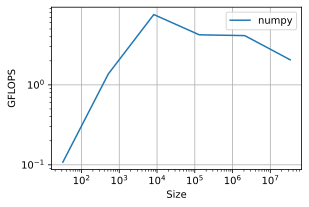

In [3]:
sizes = 2**np.arange(5, 29, 4)
np_add = lambda n: timeit.Timer(setup='import numpy as np\n'
                                'import d2ltvm\n'
                                'a, b, c = d2ltvm.get_abc(%d)' % n,
                                stmt='np.add(a, b, out=c)')
np_times = [d2ltvm.bench_workload(np_add(n).timeit) for n in sizes]
np_gflops = 2 * sizes / 1e9 /np.array(np_times)
plot_gflops(sizes, [np_gflops], ['numpy'])

As we can see that the performance first increases with the vector length, which due to the system overhead dominates when the workload is small. The performance then decreases when we cannot fit all data into the L3 cache.

## Default Scheduling

In the following block, we define a reusable function to benchmark TVM performance. It accepts a `func` which returns the schedule and variables by given the vector length. In additional, it allows to specify the machine target that can be applied to GPUs later.

In [4]:
# Save to the d2ltvm package.
def bench_vector_add_tvm(func, sizes, target):
    def workload(nrepeats):
        timer = mod.time_evaluator(mod.entry_name, ctx=ctx, number=nrepeats)
        return timer(a, b, c).mean * nrepeats
    times = []
    for n in sizes:
        s, (A, B, C) = func(int(n))
        mod = tvm.build(s, [A, B, C], target)
        ctx = tvm.context(target, 0)
        a, b, c = d2ltvm.get_abc(n, lambda x: tvm.nd.array(x, ctx=ctx))
        times.append(d2ltvm.bench_workload(workload))
    return 2 * sizes / 1e9 / np.array(times)

The default schedule is a plain a single for-loop program.

In [5]:
def default(n):
    A, B, C = d2ltvm.vector_add(n)
    s = tvm.create_schedule(C.op)
    return s, (A, B, C)

s, args = default(64)
print(tvm.lower(s, args, simple_mode=True))

produce c {
  for (i, 0, 64) {
    c[i] = (a[i] + b[i])
  }
}



Remember in :numref:`ch_cpu_arch` we found our CPU supports AVX512, we pass `-mcpu=skylake-avx512` to LLVM so that it can generate AVX2 instructions if possible. In the following codes, we print a few lines of generated LLVM codes.

In [6]:
target = 'llvm -mcpu=skylake-avx512'
mod = tvm.build(s, args, target)
print(mod.get_source()[:500])

; ModuleID = 'default_function'
source_filename = "default_function"
target datalayout = "e-m:e-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-pc-linux-gnu"

%0 = type { i8*, %1, i32, %2, i64*, i64*, i64 }
%1 = type { i32, i32 }
%2 = type { i8, i8, i16 }

@__TVMAPISetLastError = linkonce dllexport local_unnamed_addr global void (i8*)* null, align 8
@.str = private constant [69 x i8] c"Assert fail: (num_args == 3), default_function: num_args should be 3\00", align 1
@.str.1 = private co


As can be seen, it's not quite readable. In most cases, only reading the C-like pseudo codes is sufficient to debug performance. Now let's benchmark the default schedule.

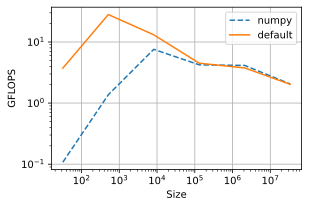

In [7]:
default_gflops = bench_vector_add_tvm(default, sizes, target)
plot_gflops(sizes, [np_gflops, default_gflops], ['numpy', 'default'])

When the vector size is small, LLVM is able to generate highly efficient machine codes. The default scheduling even outperforms NumPy. It's not surprising to find the performance degrades when increasing the vector size.

## Parallelization

One important optimization that is not enabled in default is parallelization. The vector addition operator is [embarrassingly parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel), we can just change the for-loop into a parallel for-loop. In TVM, we first obtain the scheduler for `C` by `s[C]`, and then require to parallel the computation of the first axis, which is `C.op.axis[0]`.

In [8]:
def parallel(n):
    s, (A, B, C) = default(n)
    s[C].parallel(C.op.axis[0])
    return s, (A, B, C)

s, args = parallel(64)
print(tvm.lower(s, args, simple_mode=True))

produce c {
  parallel (i, 0, 64) {
    c[i] = (a[i] + b[i])
  }
}



We can see that `for` is changed to `parallel` in the above pseudo codes. It means that the iterations could be executed in parallel. A typical implementation is we first create $n$ threads with one thread for each core, then thread $i$ will execute iteration $j$ if `j % n = i`. All these threads will run simultaneously to achieve parallelization. This is often called the [round robin scheduling](https://en.wikipedia.org/wiki/Round-robin_scheduling), which works well if each thread runs at the same speed and every iteration has a roughly same workload. Otherwise we often use the more dynamic [consumer-producer scheduling](https://en.wikipedia.org/wiki/Producer–consumer_problem).

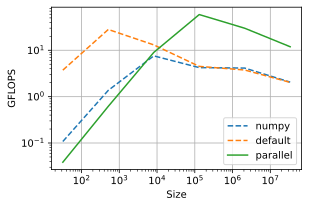

In [9]:
parallel_gflops = bench_vector_add_tvm(parallel, sizes, target)
plot_gflops(sizes, [np_gflops, default_gflops, parallel_gflops],
     ['numpy', 'default', 'parallel'])

Comparing the results we obtained before, parallelization significantly improves the performance when the workloads are large, e.g. vector lengths beyond $10^4$. Though the parallelization overhead impact the performance for small workloads, where single thread is even faster.

## Vectorization

A single core may have SIMD units to run multiple arithmetic operations at the same time as we saw in :numref:`ch_cpu_arch`. While one iteration in the above scheduling only has a single add operation. We can explicitly allocate more operation within an iteration, and ask the compiler to use SIMD instructions for them.

The way to do it is first splitting the single for-loop into two loops. The inner loop consists `factor` original iterations that will be executed in a single core with SIMD units. And iterations in the outer loop still run in parallel.

In [10]:
def vectorized(n):
    s, (A, B, C) = default(n)
    outer, inner = s[C].split(C.op.axis[0], factor=8)
    s[C].parallel(outer)
    s[C].vectorize(inner)
    return s, (A, B, C)

s, args = vectorized(64)
print(tvm.lower(s, args, simple_mode=True))

produce c {
  parallel (i.outer, 0, 8) {
    c[ramp((i.outer*8), 1, 8)] = (a[ramp((i.outer*8), 1, 8)] + b[ramp((i.outer*8), 1, 8)])
  }
}



We can see that the outer for-loop is reduced to 8 iterations, while the inner for-loop is vectorized by `ramp` with a stride of 1 and width of 8.

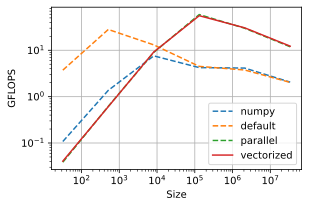

In [11]:
vectorized_gflops = bench_vector_add_tvm(vectorized, sizes, target)
plot_gflops(sizes, [np_gflops, default_gflops, parallel_gflops, vectorized_gflops],
     ['numpy', 'default', 'parallel', 'vectorized'])

The performance of the vectorized version is almost as the plain parallelization version. It's partially because the vector addition is bottlenecked by memory bandwidth instead of computation, while SIMD only helps the latter. We will see it helps more on computation intensive workloads such as matrix multiplication later.

## Summary

- The default scheduling generates highly efficient single-thread CPU program.
- Parallelization improves performance for large workloads.
- We can split a for-loop and then vectorize the inner loop to better utilize the SIMD units.